In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import re
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
from tqdm import tqdm_notebook
from collections import Counter

In [2]:
images_directory = '/kaggle/input/flickr8k/Images'
captions_path = '/kaggle/input/flickr8k/captions.txt'



In [3]:
def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
        captions = [caption.lower() for caption in captions[1:]]
    return captions

# Loading the captions from the dataset
captions = load_captions(captions_path)
captions[:15]

['1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,a girl going into a wooden building .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .\n',
 '1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a wooden cabin .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a spotted dog are fighting\n',
 '1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a white dog with brown spots are staring at each other in the street .\n',
 '1001773457_577c3a7d70.jpg,two dogs of different breeds looking at each other on the road .\n',
 '1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other .\n',
 '1002674143_1b742ab4b8.jpg,a little girl covered in paint sits in front of a painted rainbow 

In [4]:
def clean_text(text):
    # punctution marks
    text = re.sub(r'[^\w\s]', '', text)
    
    #numbers
    text = re.sub(r'\d+', '', text)
    
    #extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]
cleaned_captions[:15]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a girl going into a wooden building',
 'a little girl climbing into a wooden playhouse',
 'a little girl climbing the stairs to her playhouse',
 'a little girl in a pink dress going into a wooden cabin',
 'a black dog and a spotted dog are fighting',
 'a black dog and a tricolored dog playing with each other on the road',
 'a black dog and a white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other',
 'a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl',
 'a little girl is sitting in front of a large painted rainbow',
 'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it',
 'there is a girl with pigtails sitting in front of a rainbow painting',
 'young girl with pigtails painting outside in the grass']

In [5]:
# Image ID + \t + caption
captions_IDs = []
for i in range(len(cleaned_captions)):
    #  Adding 'start' word and 'end' word to the captions
    item = captions[i].split(',')[0]+'\t'+'start '+cleaned_captions[i]+' end\n'
    captions_IDs.append(item)
    
captions_IDs[:20:3], len(captions_IDs)

(['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
  '1000268201_693b08cb0e.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
  '1001773457_577c3a7d70.jpg\tstart a black dog and a tricolored dog playing with each other on the road end\n',
  '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n',
  '1002674143_1b742ab4b8.jpg\tstart a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it end\n',
  '1003163366_44323f5815.jpg\tstart a man lays on a bench while his dog sits by him end\n',
  '1003163366_44323f5815.jpg\tstart a shirtless man lies on a park bench with his dog end\n'],
 40455)

In [6]:
def visualaization(data, num_of_images):
    # We use dictionaries to access captions of each image by its ID
    captions_dictionary = {}
    for item in data[:(num_of_images)*5]:
        image_id, caption = item.split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)
    else:
        list_captions = [x for x in captions_dictionary.items()]
    
    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(captions_dictionary.keys()):
        captions = captions_dictionary[filename]
        try:
            image_load = load_img(images_directory+filename, target_size=(199,199,3))
        except FileNotFoundError:
            print(f"File not found")
            continue
        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()
    
visualaization(captions_IDs, 5)

File not found
File not found
File not found
File not found
File not found


<Figure size 1000x2000 with 0 Axes>

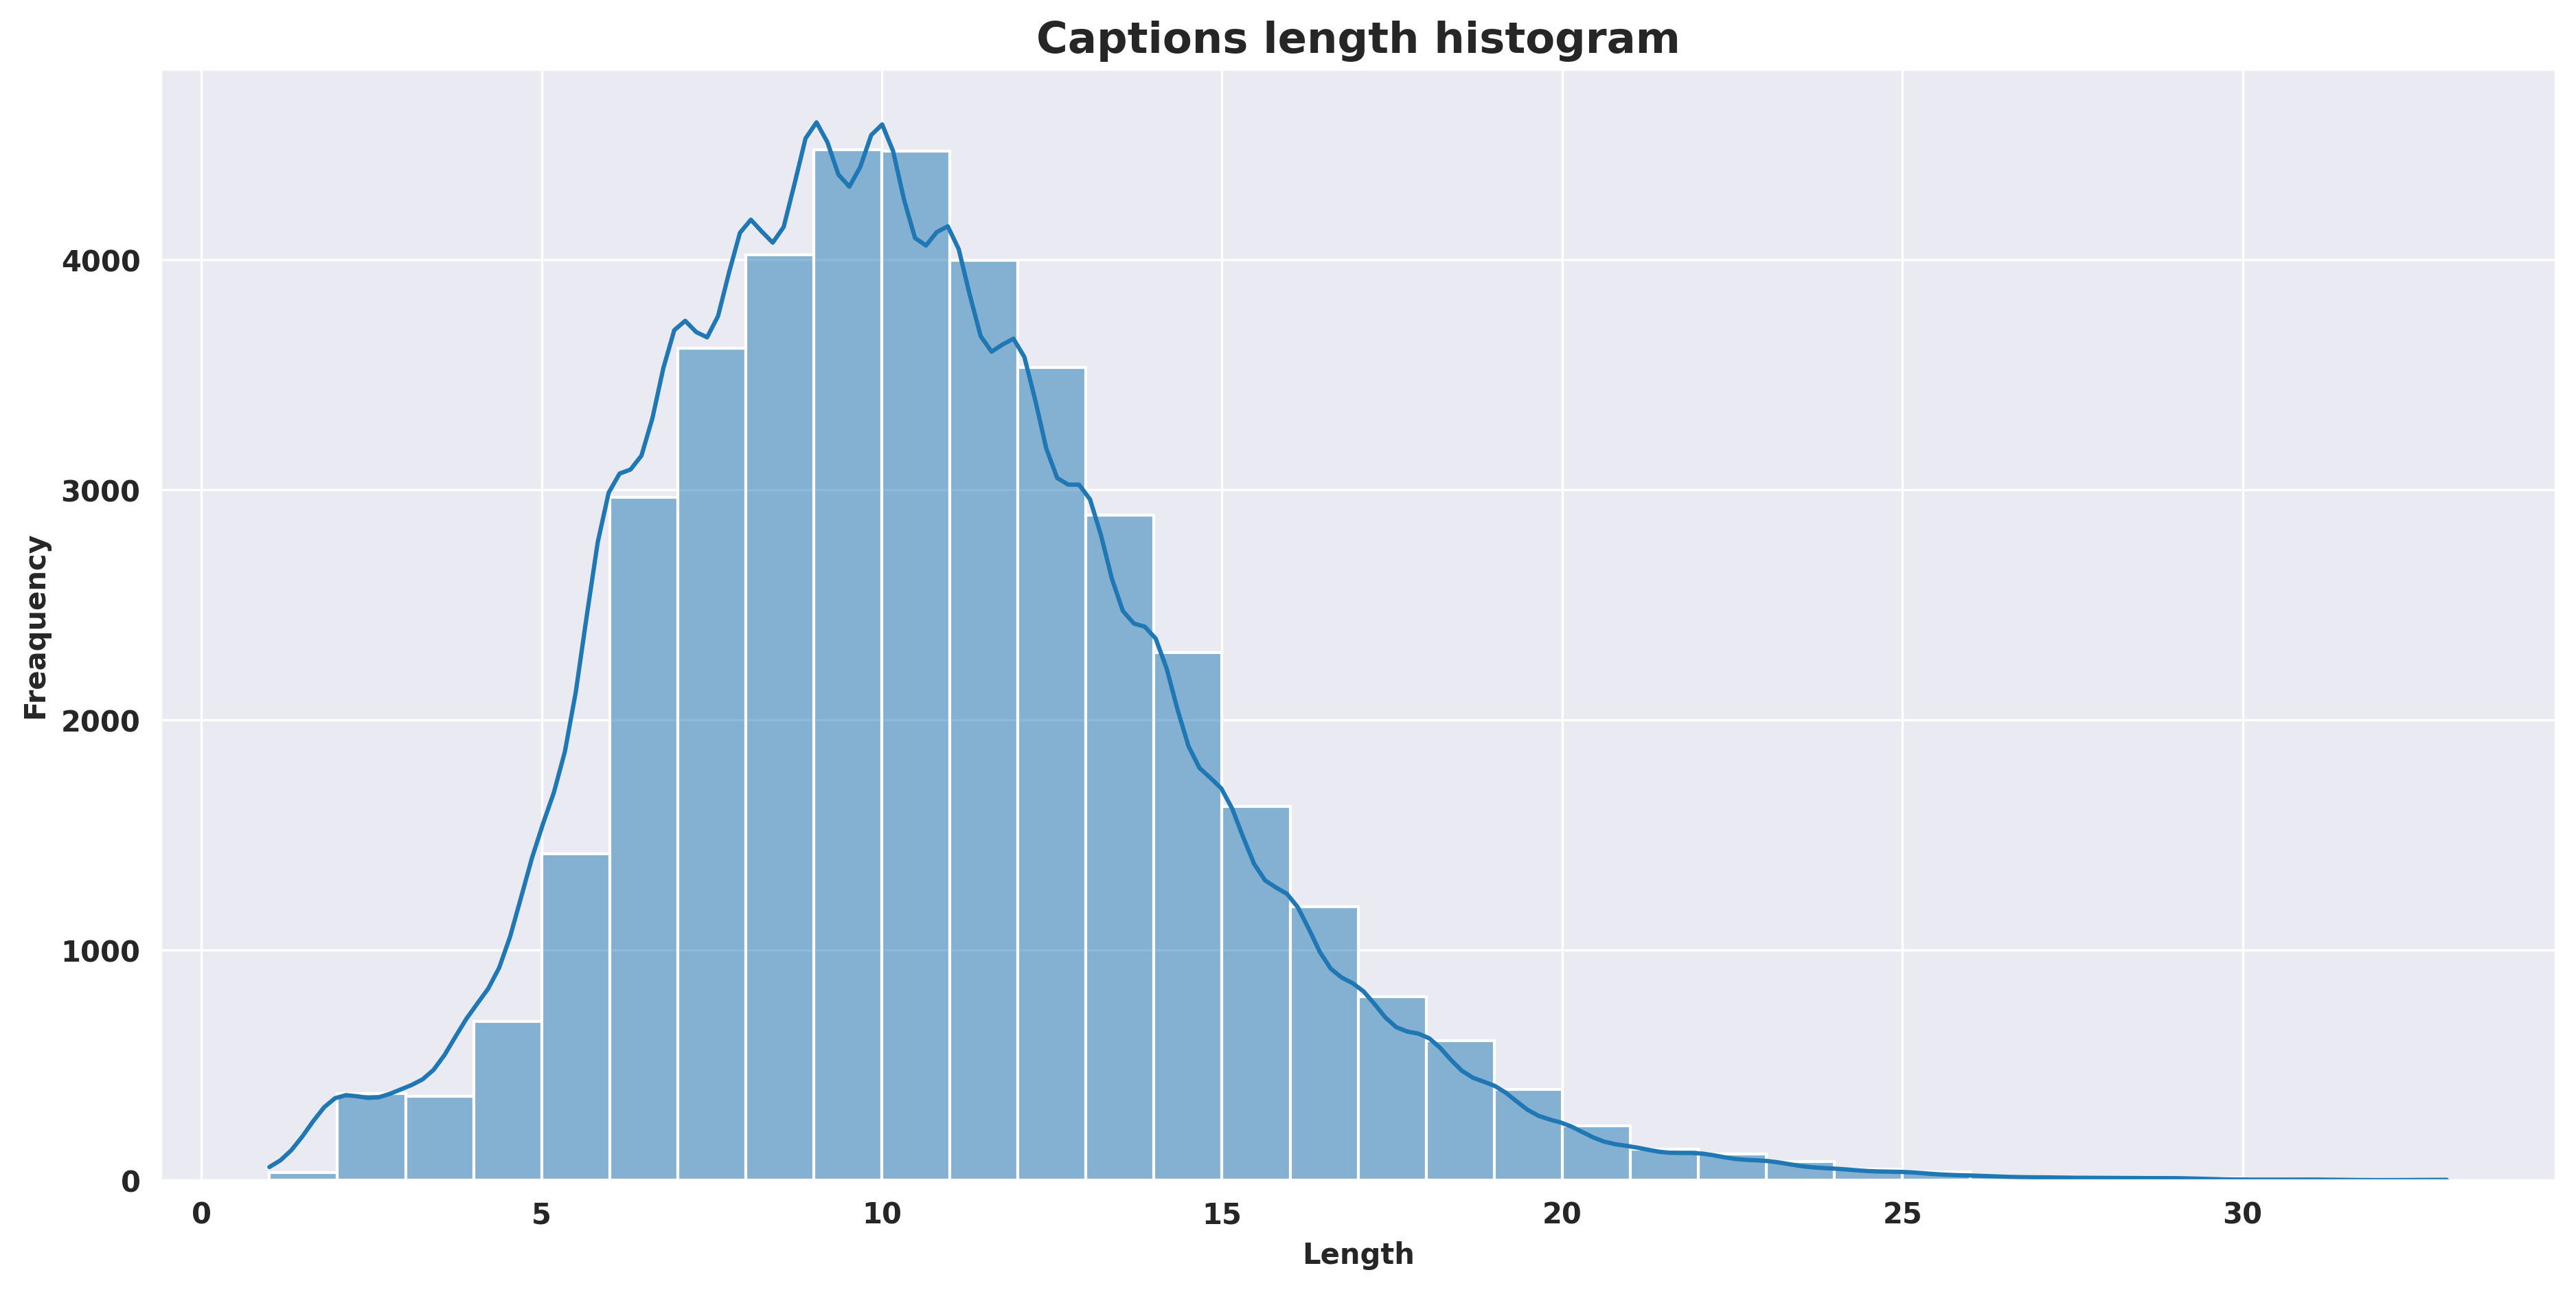

In [7]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1) 
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()
    
captions_length(cleaned_captions)

In [8]:
def word_occurrences(data):
    # Combining all sentences into a single string
    all_text = ' '.join(data)
    # Splitting the text into words and count occurrences
    word_counts = Counter(all_text.split())

    words = list(word_counts.keys())[1:30]
    values = list(word_counts.values())[1:30]

    # Normalize values to be between 0 and 1
    normalized_values = np.array(values) / np.max(values)
    colors = np.array(['rgba(30, 58, 138, {})'.format(0.4 + 0.5 * (value)) for value in normalized_values])

    fig = go.Figure(data=[go.Pie(labels=words, values=values, hole=.6, marker=dict(colors=colors), textinfo='label')])

    fig.update_layout(title_text='Word occurrences in captions (except for letter \'a\')', title_font=dict(size=23, family='Balto'))

    fig.show()
    
word_occurrences(cleaned_captions)

In [9]:
def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8586

In [10]:
tokenizer.word_index# Storing all image IDs
all_image_ids = os.listdir(images_directory)

# Splitting image IDs
train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.15, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.1, random_state=42)

train_captions, val_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_id, _ = caption.split('\t')
    
    if image_id in train_image_ids:
        train_captions.append(caption)
        
    elif image_id in val_image_ids:
        val_captions.append(caption)        

    elif image_id in test_image_ids:
        test_captions.append(caption)
        
    else:
        print('Unknown image ID !')

train_captions[0], val_captions[0], test_captions[0], len(train_captions)/5, len(val_captions)/5, len(test_captions)/5

('1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
 '1001773457_577c3a7d70.jpg\tstart a black dog and a spotted dog are fighting end\n',
 '1042590306_95dea0916c.jpg\tstart a man and woman pose for the camera while another man looks on end\n',
 6877.0,
 1092.0,
 122.0)

In [11]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def extract_image_features(model, image_path):
    img = preprocess_image(image_path)
    features = model.predict(img, verbose=0)
    return features

# Loading the pre-trained InceptionV3 model
inception_v3_model = InceptionV3(weights = 'imagenet', input_shape=(299, 299, 3))
inception_v3_model.layers.pop()
inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [12]:
train_image_features, val_image_features, test_image_features = {}, {}, {}  # A Dictionary to store image features with their corresponding IDs       

pbar = tqdm_notebook(total=len(all_image_ids), position=0, leave=True, colour='green') 

for caption in all_image_ids:
    image_id = caption.split('\t')[0]
    image_path = os.path.join(images_directory, image_id)
    image_features = extract_image_features(inception_v3_model, image_path) # Extracting features
    
    if image_id in train_image_ids:
        train_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)
    
    elif image_id in val_image_ids:
        val_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)
    
    elif image_id in test_image_ids:
        test_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)
    
    else:
        print('Unknown image ID !')
    
pbar.close()

  0%|          | 0/8091 [00:00<?, ?it/s]

In [13]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    while True:
        np.random.shuffle(image_ids)  # Shuffle image_ids for each epoch
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                seq = tokenizer.texts_to_sequences([caption_text])[0] # Tokenizing the caption
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i] # X_caption, Y
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length, padding = 'post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)
            
            yield (np.array(X_images), np.array(X_captions)), np.array(y)
         
        
# Defining the maximum length of captions
max_caption_length = max(len(caption.split()) for caption in cleaned_captions) + 1

# Defining the CNN output dimension (size of feature vector from InceptionV3)
cnn_output_dim = inception_v3_model.output_shape[1] # 2048

# Defining batch size
batch_size_train = 270
batch_size_val = 150

# Creating data generators for training and validation
train_data_generator = data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train)
val_data_generator = data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val)

max_caption_length

34

In [14]:
# Checking shapes
sample_batch = next(train_data_generator)
print("Training sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)
print('========')
sample_batch = next(val_data_generator)
print("Validation sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)

Training sample batch shapes:
X_images: (3230, 2048)
X_captions: (3230, 34)
y: (3230, 8586)
Validation sample batch shapes:
X_images: (1676, 2048)
X_captions: (1676, 34)
y: (1676, 8586)


In [15]:
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    # Encoder Model
    # Encoder
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    x = BatchNormalization()(input_image)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    encoded_image = Dense(256, activation='relu')(x)

    # Decoder
    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    embedded_caption = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(input_caption)
    lstm_output = LSTM(256)(embedded_caption)

    # Merge encoder + decoder
    merged = Concatenate()([encoded_image, lstm_output])
    decoder = Dense(256, activation='relu')(merged)
    decoder = Dropout(0.5)(decoder)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder)

    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning_Better')
    return model
    
# Building the model
caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)

optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

caption_model.summary()

Model: "Image_Captioning_Better"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Features_Input            │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 2048)           │          8,192 │ Features_Input[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │      1,049,088 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 512)            │          2,048 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Sequence_Input            │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 512)            │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 34, 256)        │      2,198,016 │ Sequence_Input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 34)             │              0 │ Sequence_Input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ embedding[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 512)            │              0 │ dense_1[0][0],         │
│ (Concatenate)             │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        131,328 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Output_Layer (Dense)      │ (None, 8586)           │      2,206,602 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,251,914 (23.85 MB)

 Trainable params: 6,246,794 (23.83 MB)

 Non-trainable params: 5,120 (20.00 KB)

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
     return lr * tf.math.exp(-0.6)

# # Learning Rate Scheduler
lr_schedule = LearningRateScheduler(lr_scheduler)

history = caption_model.fit(train_data_generator, steps_per_epoch=len(train_captions) // batch_size_train,
                        validation_data=val_data_generator, validation_steps=len(val_captions) // batch_size_val,
                        epochs=20, callbacks=[early_stopping])

print("training Complete")

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 67s 485ms/step - loss: 5.6190 - val_loss: 3.9077
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 61s 481ms/step - loss: 3.9085 - val_loss: 3.5404
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 61s 487ms/step - loss: 3.5757 - val_loss: 3.4248
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 511ms/step - loss: 3.3923 - val_loss: 3.3524
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 59s 469ms/step - loss: 3.2666 - val_loss: 3.3077
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 59s 466ms/step - loss: 3.1747 - val_loss: 3.2973
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 61s 487ms/step - loss: 3.0937 - val_loss: 3.2788
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 62s 487ms/step - loss: 3.0229 - val_loss: 3.2734
Epoch 9/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 62s 487ms/step - loss: 2.9690 - val_loss: 3.2981
Epoch 10/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 61s 483ms/step - loss: 2.9322 - val_loss: 3.3399
Epoch 11/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 61s 485ms/step - loss: 2.8995 - val_loss: 3.2998
training Complete


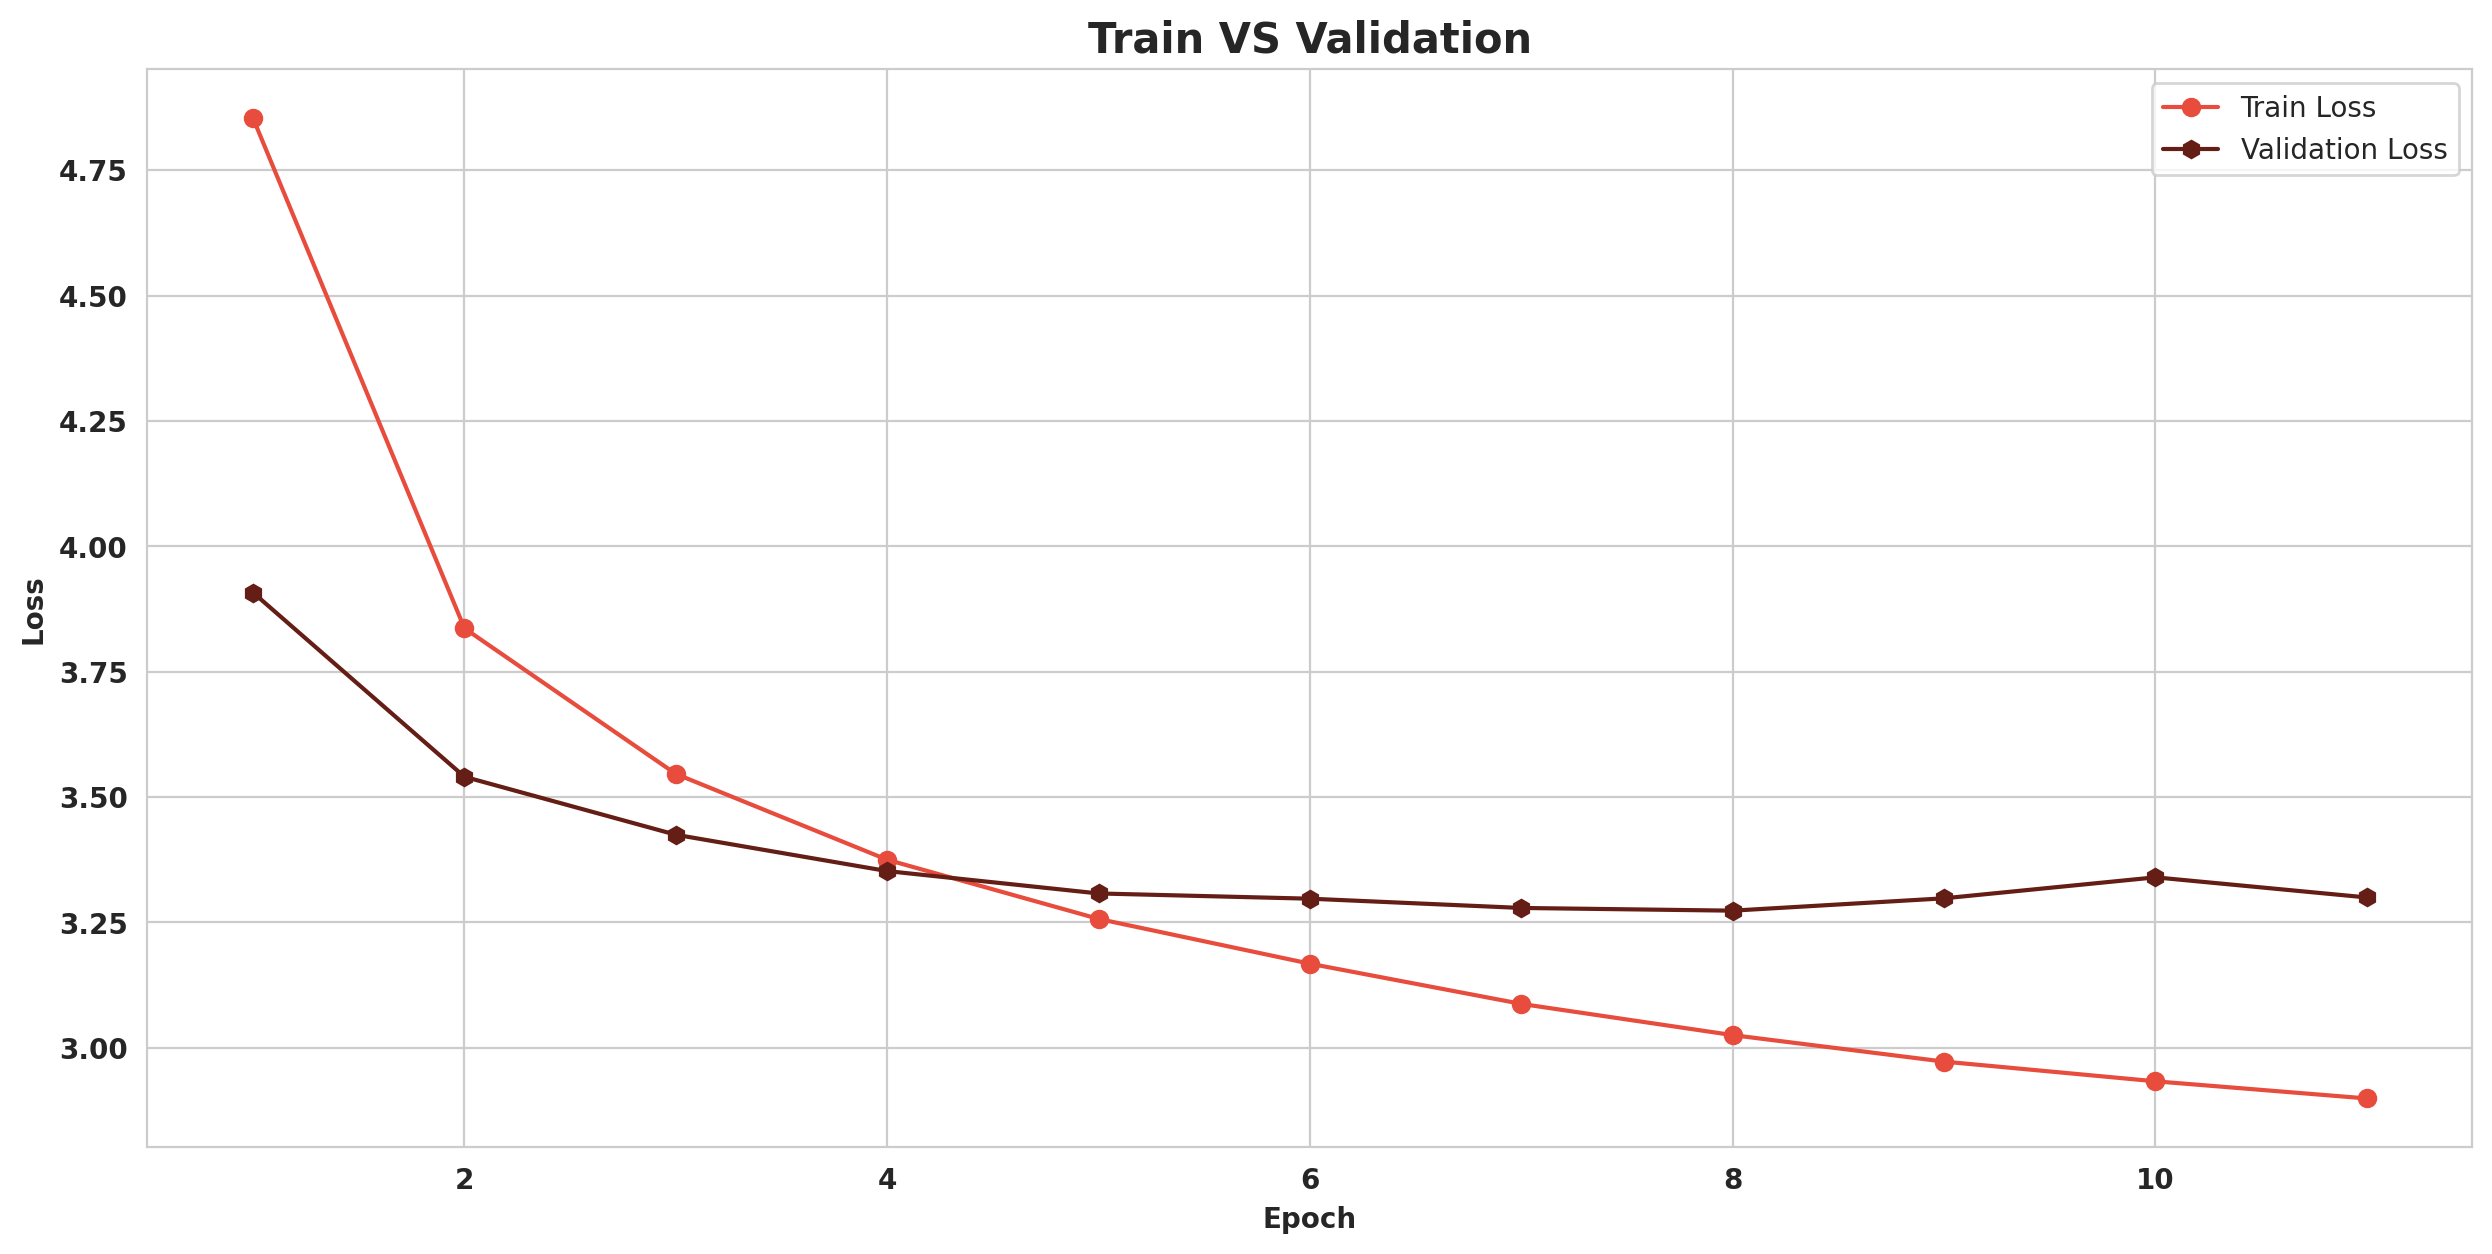

In [32]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

Test img process

In [33]:
def greedy_generator(image_features): # A function to generate captions
    # Each caption is started with the word 'start'
    in_text = 'start '
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length, padding='post').reshape((1, max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word[idx]
        # Adding the predicted word to the sequence
        in_text += ' ' + word
        # When the model returns the word 'end' (which is the end word), the generating loop must be stopped 
        if word == 'end':
            break
            
    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')
    
    return in_text

In [34]:
def beam_search_generator(image_features, K_beams = 3, log = False):
    start = [tokenizer.word_index['start']]
    
    start_word = [[start, 0.0]]
    
    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            # Sequence of most probable words based on the previous steps
            sequence = pad_sequences([s[0]], maxlen=max_caption_length, padding='post')
            
            preds = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
            
            # Sorting predictions by the probability and taking the last K_beams items.
            word_preds = np.argsort(preds[0])[-K_beams:]
            
            # Getting the top <K_beams>(n) predictions and creating a 
            #                              new list so as to put them via the model again.
            for w in word_preds:
                
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
                
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

        # Getting the top words
        start_word = start_word[-K_beams:]
    
    start_word = start_word[-1][0]
    captions_ = [tokenizer.index_word[i] for i in start_word]

    final_caption = []
    
    for i in captions_:
        if i != 'end':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [35]:
# Calculates BLEU score of predictions
def BLEU_score(actual, greedy, beam_search):
    # Calculating the BLEU score by comparing the predicted caption with five actual captions.
    score_greedy_1 = corpus_bleu(actual, greedy, weights=(0.3, 0.3, 0.3, 0))
    score_greedy_2 = corpus_bleu(actual, greedy, weights=(0.25, 0.25, 0.25, 0.25))
    score_BS_1 = corpus_bleu(actual, beam_search, weights=(0.3, 0.3, 0.3, 0))
    score_BS_2 = corpus_bleu(actual, beam_search, weights=(0.25, 0.25, 0.25, 0.25))
    
    return [
        (f'BLEU-2 Greedy: {round(score_BS_2, 5)}'),
        (f'BLEU-1 Greedy: {round(score_BS_1, 5)}'),
        (f'Greedy: {greedy[0]}'),
        (f'BLEU-2 Beam Search: {round(score_greedy_2, 5)}'),
        (f'BLEU-1 Beam Search: {round(score_greedy_1, 5)}'),
        (f'Beam Search:  {beam_search[0]}')
    ]

In [36]:
# A dictionary to access actual captions of each image by its ID
test_actual_captions = {}
for item in test_captions:
    image_id, caption = item.split('\t')
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(caption)

In [37]:
generated_captions = {}

pbar = tqdm_notebook(total=len(test_image_features), position=0, leave=True, colour='green')
for image_id in test_image_features:
    cap = greedy_generator(test_image_features[image_id])
    generated_captions[image_id] = cap
    pbar.update(1)
    
pbar.close()

  0%|          | 0/122 [00:00<?, ?it/s]

Test img with caption


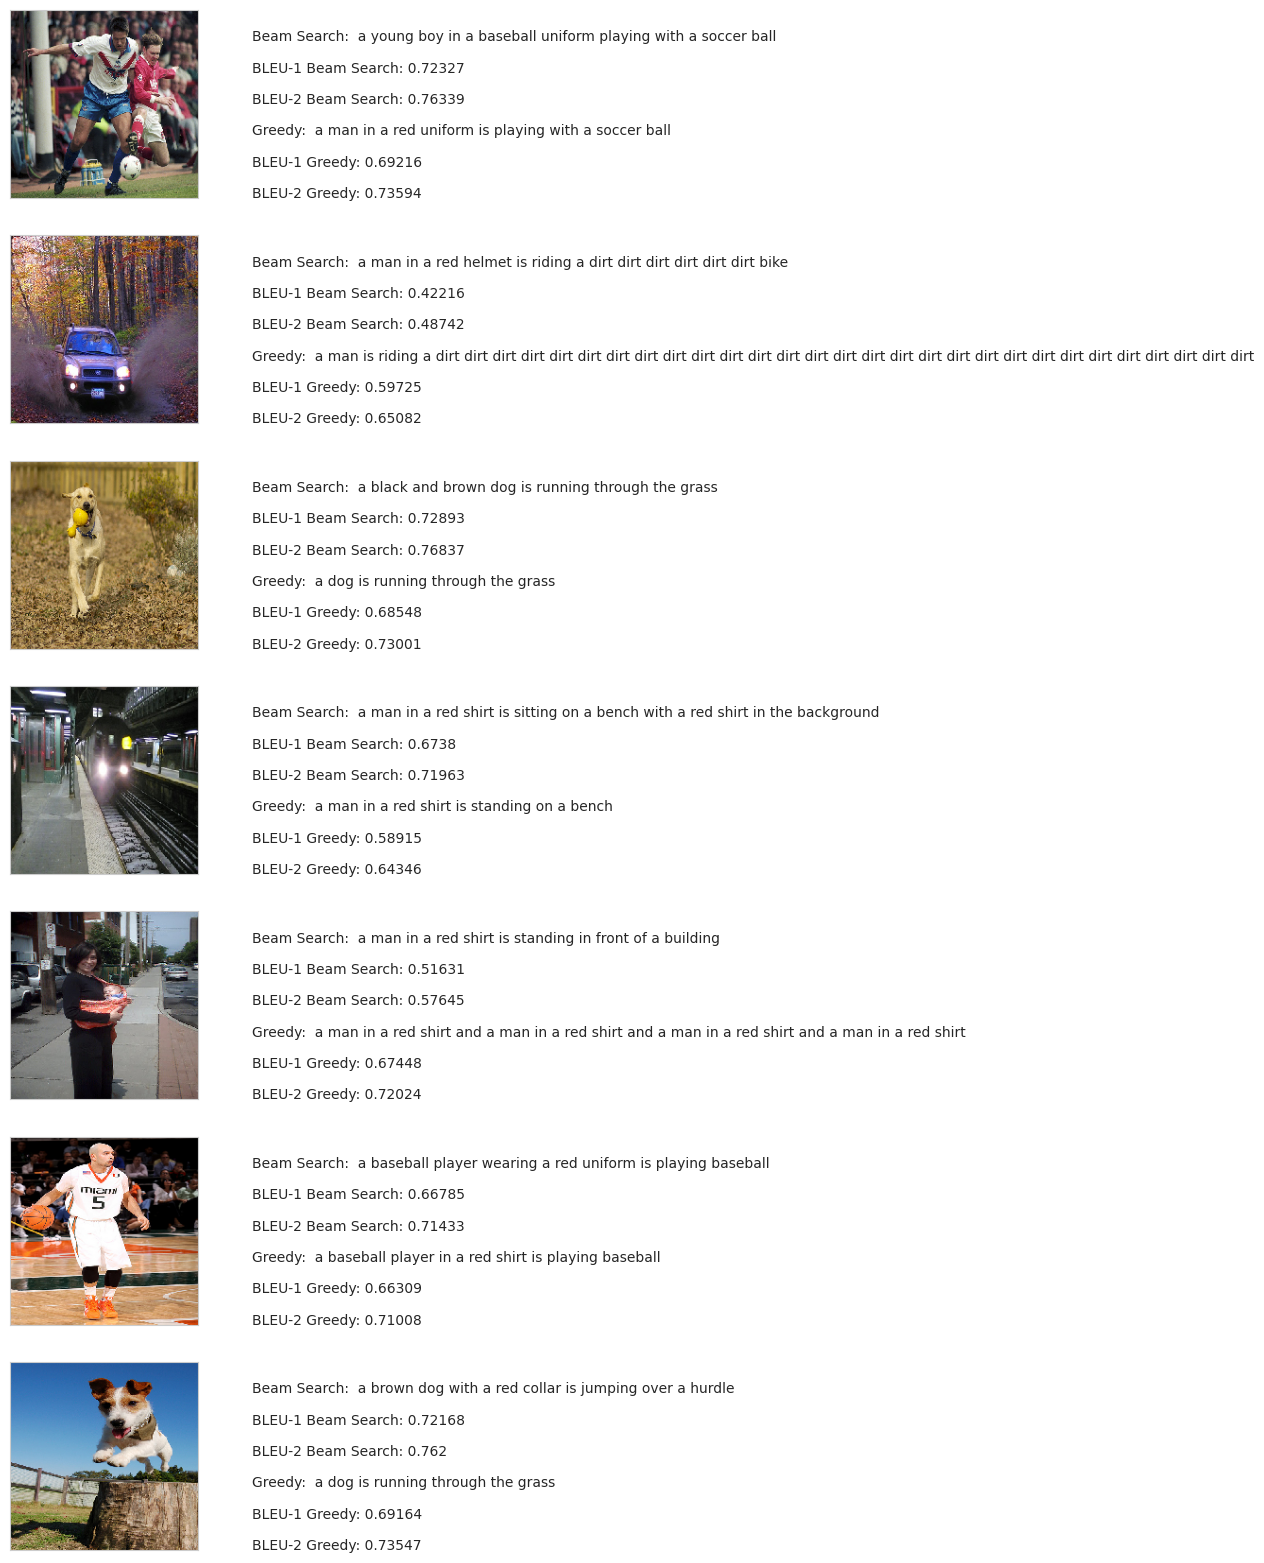

In [38]:
import os
from keras.utils import load_img
import matplotlib.pyplot as plt
import numpy as np

def visualization(data, greedy_caps, beamS_generator, evaluator, num_of_images):
    keys = list(data.keys())  # List of all test images
    images = [np.random.choice(keys) for _ in range(num_of_images)]  # Randomly selected images

    count = 1
    fig = plt.figure(figsize=(6, 20))

    for filename in images:
        actual_cap = data[filename]
        actual_cap = [x.replace("start ", "").replace(" end", "") for x in actual_cap]

        # Generate captions
        greedy_cap = greedy_caps[filename]
        beamS_cap = beamS_generator(test_image_features[filename])

        # Get BLEU scores
        caps_with_score = evaluator(actual_cap, [greedy_cap] * len(actual_cap), [beamS_cap] * len(actual_cap))

        # Load and show image
        image_path = os.path.join(images_directory, filename)
        try:
            image_load = load_img(image_path, target_size=(199, 199, 3))
        except FileNotFoundError:
            print(f"File not found: {image_path}")
            continue

        ax = fig.add_subplot(num_of_images, 2, count, xticks=[], yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images, 2, count)
        plt.axis('off')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, len(caps_with_score))
        for i, text in enumerate(caps_with_score):
            ax.text(0, i, text, fontsize=10)
        count += 1

    plt.tight_layout()
    plt.show()



visualization(test_actual_captions, generated_captions, beam_search_generator, BLEU_score, 7)

In [39]:
caption_model.save('/kaggle/working/caption_model.keras')

In [40]:
import pickle

with open('/kaggle/working/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [27]:
caption_model = load_model('caption_model.keras')

with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [28]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np

# Load InceptionV3 model for feature extraction
base_model = InceptionV3(weights='imagenet')
model_extract = Model(base_model.input, base_model.layers[-2].output)  # typically shape (2048,)

def extract_features(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model_extract.predict(x)
    return features


In [29]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np

def predict_caption(img_path, model, tokenizer, max_caption_length):
    photo = extract_features(img_path)
    in_text = 'start'
    
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length, padding='post')
        yhat = model.predict([photo, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
            
    return in_text.replace('start', '').replace(' end', '').strip()


In [30]:
caption = predict_caption("/kaggle/input/flickr8k/Images/1003163366_44323f5815.jpg", caption_model, tokenizer, max_caption_length=34)
print("Predicted:", caption)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted: a dog is jumping over a red and white pole
